BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Testo:
Late pushback due to hydraulic pump issue discovered during final check.

Predizione: TECHNICAL_FAILURE
Confidence per classe:
  TECHNICAL_FAILURE: 0.774
  CREW_DELAY: 0.038
  WEATHER: 0.053
  ATC_RESTRICTION: 0.046
  LOGISTICS_ISSUE: 0.063
  SECURITY: 0.026


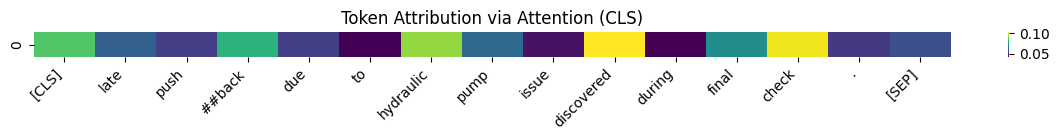

Testo:
Security check delayed boarding due to missing documents.

Predizione: TECHNICAL_FAILURE
Confidence per classe:
  TECHNICAL_FAILURE: 0.226
  CREW_DELAY: 0.137
  WEATHER: 0.193
  ATC_RESTRICTION: 0.117
  LOGISTICS_ISSUE: 0.168
  SECURITY: 0.159


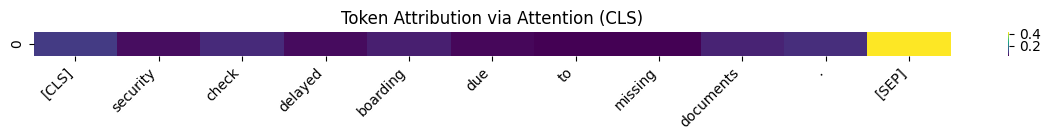

--------------------------------------------------------------------------------
Testo:
Flight held on ground due to ATC congestion at destination.

Predizione: ATC_RESTRICTION
Confidence per classe:
  TECHNICAL_FAILURE: 0.083
  CREW_DELAY: 0.181
  WEATHER: 0.118
  ATC_RESTRICTION: 0.469
  LOGISTICS_ISSUE: 0.060
  SECURITY: 0.089


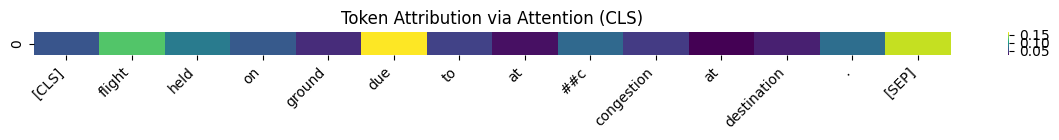

--------------------------------------------------------------------------------
Testo:
Crew change required after maximum duty time exceeded.

Predizione: CREW_DELAY
Confidence per classe:
  TECHNICAL_FAILURE: 0.239
  CREW_DELAY: 0.301
  WEATHER: 0.196
  ATC_RESTRICTION: 0.089
  LOGISTICS_ISSUE: 0.114
  SECURITY: 0.060


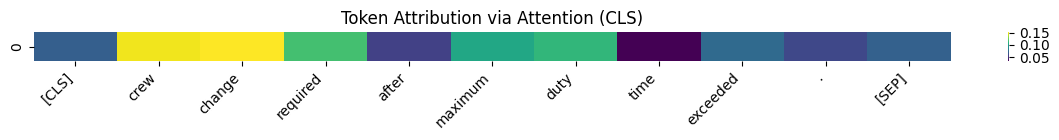

--------------------------------------------------------------------------------
Testo:
Low visibility required additional de-icing before departure.

Predizione: WEATHER
Confidence per classe:
  TECHNICAL_FAILURE: 0.283
  CREW_DELAY: 0.172
  WEATHER: 0.346
  ATC_RESTRICTION: 0.066
  LOGISTICS_ISSUE: 0.094
  SECURITY: 0.040


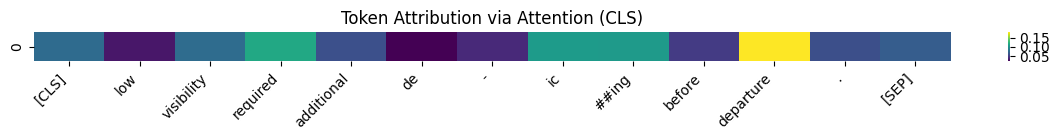

--------------------------------------------------------------------------------


In [2]:
# Aircraft Delay Log - Interpretabilità e Analisi

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Carica modello fine-tuned
model = AutoModelForSequenceClassification.from_pretrained("../model/delay_classifier", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model.eval()

label_map = {
    0: "TECHNICAL_FAILURE",
    1: "CREW_DELAY",
    2: "WEATHER",
    3: "ATC_RESTRICTION",
    4: "LOGISTICS_ISSUE",
    5: "SECURITY"
}

# Funzione: visualizzazione heatmap di attenzione
def visualize_attention(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # tuple of layers

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    attn_weights = attentions[-1]  # last layer
    attn = attn_weights.mean(dim=1)[0][0].detach().numpy()  # avg over heads, focus on CLS token

    plt.figure(figsize=(12, 1.5))
    sns.heatmap([attn], cmap="viridis", xticklabels=tokens, cbar=True)
    plt.xticks(rotation=45, ha="right")
    plt.title("Token Attribution via Attention (CLS)")
    plt.tight_layout()
    plt.show()

# Funzione: predizione con score
def predict_and_explain(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).numpy().flatten()
        prediction = torch.argmax(logits, dim=1).item()
    print(f"Testo:\n{text}\n")
    print("Predizione:", label_map[prediction])
    print("Confidence per classe:")
    for i, p in enumerate(probs):
        print(f"  {label_map[i]}: {p:.3f}")
    visualize_attention(text)

# Esempio testuale
example = "Late pushback due to hydraulic pump issue discovered during final check."
predict_and_explain(example)

# Altri test
examples = [
    "Security check delayed boarding due to missing documents.",
    "Flight held on ground due to ATC congestion at destination.",
    "Crew change required after maximum duty time exceeded.",
    "Low visibility required additional de-icing before departure.",
]

for txt in examples:
    predict_and_explain(txt)
    print("-" * 80)
